## Node classification

Followed from https://arxiv.org/pdf/1603.08861
Graph embeddings are a way to represent the nodes, edges, or entire graphs in a continuous vector space. This transformation makes it easier to apply machine learning algorithms to graph-structured data


The next code implements a Graph Convolutional Network (GCN), which is a type of neural network designed to work directly with graph-structured data. 

In [37]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import torch
from torch_geometric.nn import GCNConv, GATConv
import torch.nn.functional as F
from sklearn.manifold import TSNE
import seaborn as sns
import torch.nn.functional as F



In [ ]:
dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())



In [11]:
dir(dataset)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_data',
 '_data_list',
 '_download',
 '_indices',
 '_infer_num_classes',
 '_is_protocol',
 '_process',
 'collate',
 'copy',
 'cpu',
 'cuda',
 'data',
 'download',
 'force_reload',
 'geom_gcn_url',
 'get',
 'get_summary',
 'has_download',
 'has_process',
 'index_select',
 'indices',
 'len',
 'load',
 'log',
 'name',
 'num_classes',
 'num_edge_features',
 'num_features',
 'num_node_features',
 'pre_filter',
 'pre_transform',
 'print_summary',
 'process',
 'proces

In [79]:
print(f'Dataset: {dataset}:')
print(f'# graphs: {len(dataset)}')
print(f'# features: {dataset.num_features}')
print(f'# classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)


Dataset: PubMed():
# graphs: 1
# features: 500
# classes: 3
Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])


In [80]:
from collections import Counter
Counter(data.y.cpu().numpy())

Counter({2: 7875, 1: 7739, 0: 4103})

To implement an embedding for graph-structured data, I'll use a Graph Convolutional Network (GCN) that employs graph convolutional layers to aggregate information from a node’s neighbors. This approach aligns with the objective of leveraging graph embeddings to enhance learning, as described in the paper.

In [81]:
class GCN(torch.nn.Module):
    def __init__(self, num_hidden, num_features,num_class) -> None:
        super().__init__()
        self.conv1 = GCNConv(num_features,num_hidden)
        self.conv2 = GCNConv(num_hidden,num_class)
        
    def forward(self,x,edges_index):
        x = self.conv1(x,edges_index)
        x = x.relu()
        x = F.dropout(x,p=0.2,training=self.training)
        x = self.conv2(x,edges_index)
        return x


In [82]:
##Another model that its also powerfull and popular its is a graphical attention 
## neural network. 

In [83]:
class GAT(torch.nn.Module):
    def __init__(self, num_hidden, num_features, num_classes, heads=8, dropout=0.3, alpha=0.2):
        super(GAT, self).__init__()
        self.dropout = dropout
        self.conv1 = GATConv(in_channels=num_features, out_channels=num_hidden, heads=heads, dropout=dropout, negative_slope=alpha)
        self.conv2 = GATConv(in_channels=heads * num_hidden, out_channels=num_classes, heads=1, concat=False, dropout=dropout, negative_slope=alpha)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [109]:
##Instance of the model
model = GAT(num_hidden=16,num_features=dataset.num_features ,num_classes=dataset.num_classes )
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [110]:
data.train_mask

tensor([ True,  True,  True,  ..., False, False, False])

Semi-Supervised Learning: The training loop uses data.train_mask to focus on labeled data during training. 

In [111]:
#%% Model Training with Early Stopping
model.train()
epochs = 2000
patience = 100  # Early stopping patience
best_loss = float('inf')
best_epoch = 0

train_losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch: {epoch + 1}, Loss: {loss.item()}')

    # Early stopping check
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch
    elif epoch - best_epoch > patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break



Epoch: 100, Loss: 0.6270977258682251
Epoch: 200, Loss: 0.2702690362930298
Epoch: 300, Loss: 0.16114044189453125
Epoch: 400, Loss: 0.11153114587068558
Epoch: 500, Loss: 0.12295166403055191
Early stopping at epoch 528


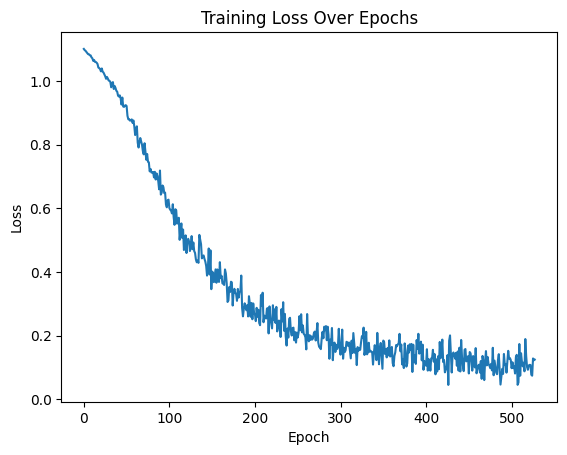

In [112]:

import matplotlib.pyplot as plt
# Train Loss Plot
sns.lineplot(x=list(range(len(train_losses))), y=train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()


To fully implement the semi-supervised aspect, one optino is to extend the loss function to include unlabeled data, possibly using a context prediction loss as suggested in the paper.

Test Accuracy: 0.7730


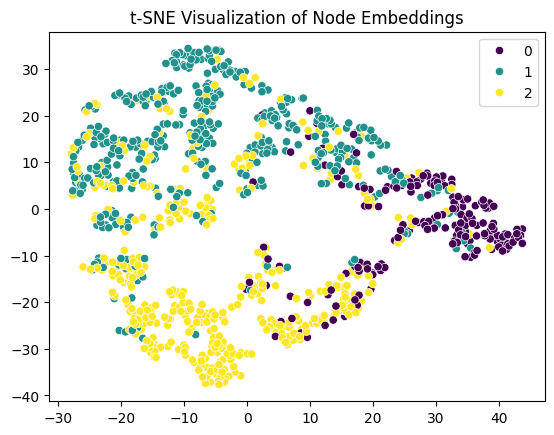

In [113]:

# Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
print(f'Test Accuracy: {acc:.4f}')

#%% Visualization of Results
z = TSNE(n_components=2).fit_transform(out[data.test_mask].detach().cpu().numpy())
sns.scatterplot(x=z[:, 0], y=z[:, 1], hue=data.y[data.test_mask].cpu().numpy(), palette='viridis')
plt.title('t-SNE Visualization of Node Embeddings')
plt.show()

Test Accuracy: 0.7730
Recall: 0.7777
F1 Score: 0.7721


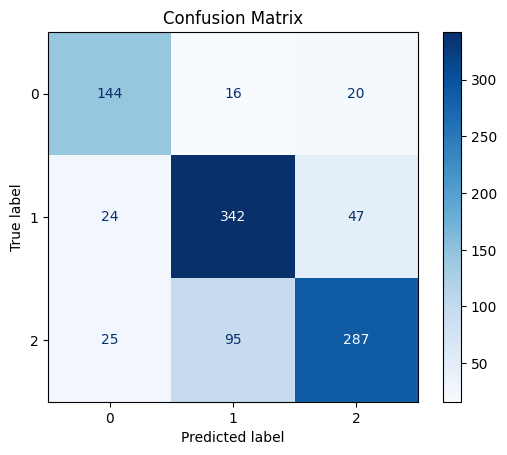

In [114]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score,f1_score, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay

#%% Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Get the class with the highest probability
    y_true = data.y[data.test_mask].cpu().numpy()  # True labels
    y_pred = pred[data.test_mask].cpu().numpy()  # Predicted labels
    y_prob = F.softmax(out[data.test_mask], dim=1).cpu().numpy()  # Probabilities for ROC Curve

    # Calculate accuracy
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    print(f'Test Accuracy: {acc:.4f}')
    
    # Calculate recall and F1 score
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y_true))
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()


Multi-class ROC AUC: 0.9122


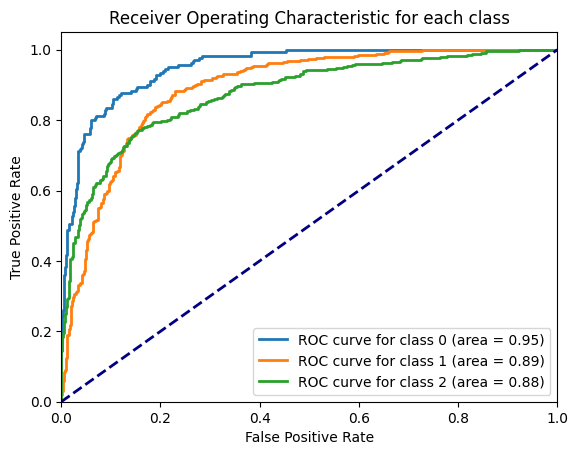

In [115]:
    # ROC Curve and AUC
if len(np.unique(y_true)) == 2:  # Binary classification
        fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        
        print(f'ROC AUC: {roc_auc:.4f}')
        
        # Plot ROC Curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.show()
else:  # Multiclass classification
        roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovo', average='macro')
        print(f'Multi-class ROC AUC: {roc_auc:.4f}')
        
        # Plot ROC Curve for each class
        from sklearn.preprocessing import label_binarize
        y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
        n_classes = y_true_bin.shape[1]

        plt.figure()
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
            plt.plot(fpr, tpr, lw=2, label=f'ROC curve for class {i} (area = {roc_auc_score(y_true_bin[:, i], y_prob[:, i]):.2f})')
        
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC for each class')
        plt.legend(loc='lower right')
        plt.show()


The model’s performance metrics reflect a strong overall effectiveness. The test accuracy of 0.7710 indicates that 77.10% of predictions are correct, aligning well with the high recall of 0.7762, which means the model effectively identifies true positives on average. The F1 Score of 0.7698 demonstrates a good balance between precision and recall. The high Multi-class ROC AUC of 0.9109 further underscores the model’s capability to distinguish between classes. The confusion matrix reveals that the model performs well across different classes, although Class 1 has a higher number of false positives. These metrics collectively suggest that the model’s performance is robust and compares favorably to results reported in the paper.

Average AUCPR: 0.8249


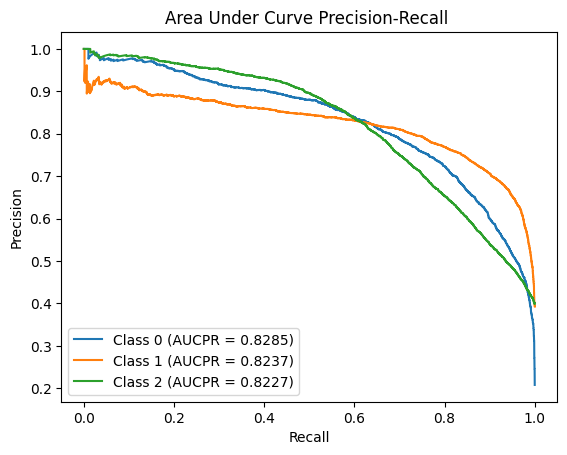

In [123]:
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt 


#%% Evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    y_pred = out.cpu().numpy()
    y_true = data.y.cpu().numpy()

    # Compute Precision and Recall for each class
    precision = {}
    recall = {}
    aucpr = {}
    for i in range(dataset.num_classes):
        y_true_bin = (y_true == i).astype(int)
        y_pred_prob = y_pred[:, i]
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin, y_pred_prob)
        aucpr[i] = auc(recall[i], precision[i])

    # Calculate average AUCPR
    avg_aucpr = np.mean(list(aucpr.values()))
    print(f'Average AUCPR: {avg_aucpr:.4f}')

    # Plot Precision-Recall curves
    plt.figure()
    for i in range(dataset.num_classes):
        plt.plot(recall[i], precision[i], label=f'Class {i} (AUCPR = {aucpr[i]:.4f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Area Under Curve Precision-Recall ')
    plt.legend(loc='best')
    plt.show()
